## <center> **<span style="color: red">NLP</span> steps and explnation.**

Here we will use <span style="color: #ffd21e">**Hugging face**</span> trasformers pre trained models becuase it'll take so much effort to label<br>
all of our text columns "<ins>Comments, Describtion, Title</ins>" and also we will extract categorical and numirecal<br>
features from the text columns.<br><br>

##### **Steps in detail:**
<ul>
    <li>Extract categorical features from text columns sush as:<ol> 
        <li>Contains emojies
        <li>Positive or negative
        <li>Language
        <li>Video stats range</ol>
    <li> Doing analysis for most common words in comments and titles (Word cloud)
    <li> Extracing the length of the comments, descriptions & titles
    <li> One hot encoding
    <li> Stemming the data and tokenizing it
    <li> Saving those new data into new <strong>one</strong> Df to use in the final ML model

##### **Important note:**
The data in this analysis may be a little bit biased becuase all comments is made to be at least more than <br>
$50$.

## <center> **Importing the <span style="color: red">Packeges</span>**<br>

In [96]:
import re
import os
import ast
import time
import nltk
import emoji
import pickle
import sqlite3
import numpy as np

import pandas as pd
import transformers
from dash import html, callback, Input, Output, register_page, dcc

from PIL import Image
import huggingface_hub
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from IPython.display import display, Markdown
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from IPython.display import set_matplotlib_formats
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import (WordCloud,
                       STOPWORDS,
                       ImageColorGenerator)

In [2]:
with open("../Data analysis/functions/z-score.pickle", "rb") as f:
    z_score = pickle.load(f)

%matplotlib inline
huggingface_hub.notebook_login()
set_matplotlib_formats('pdf', 'svg')

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_15180\3753516804.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


## <center> **Reading the <span style="color: red">data</span>**

In [3]:
TEXT_COLUMNS = ["title", "comments", "description", "channelTitle", "about"]
NUMERICS = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64',
            'uint16', 'uint32', 'uint64', float, int]

con = sqlite3.connect('../database.db')

df = pd.read_sql_query("""

                        SELECT *
                        FROM base_videos AS bv

                        INNER JOIN base_channels  AS bc ON
                            bc.channel_name = bv.channelTitle

                        INNER JOIN comments  AS c ON
                            c.video_id = bv.video_id""", con)

con.close()

df = df.T.drop_duplicates().T # dropping duplicated cols

In [4]:
df = df.sample(50)

##  <center> **Extract <span style="color: red">categorical</span> features**

#### *Extract emojies count per text*

In [5]:
comments_emojis_counts: list = []
title_emojis_counts: list = []
desc_emojis_counts: list = []

for comment, title, desc in zip(df["comments"], df["title"], df["description"]):
    
    comments_emojis_count: int = 0
    title_emojis_count: int = 0
    desc_emojis_count: int = 0
    
    for comment_char, title_char, desc_char in zip(comment, title, desc):
        
        if emoji.is_emoji(comment_char):
            comments_emojis_count += 1
            
        if emoji.is_emoji(title_char):
            title_emojis_count += 1
            
        if emoji.is_emoji(desc_char):
            desc_emojis_count += 1
    
    comments_emojis_counts.append(comments_emojis_count)
    title_emojis_counts.append(title_emojis_count)
    desc_emojis_counts.append(desc_emojis_count)

In [6]:
df["comments_emojis_count"] = comments_emojis_counts
df["title_emojis_count"] = title_emojis_counts
df["desc_emojis_count"] = desc_emojis_counts

df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,...,date,video_count,about,country,comments,like_counts,reply_counts,comments_emojis_count,title_emojis_count,desc_emojis_count
2400,P9YLHkUX4dQ,Enjoy gaming,Top 17 Big Changes Of OB38 Updates Of Free Fir...,#ob38update #ob38 #freefirenewupdateob38\n\nFr...,[],2023-01-02 07:20:02+00:00,76473,5720,134,hd,...,2020-09-22 00:00:00,777,Hi this is Official channel of Enjoy gaming.\n...,IN,Agar garena ne ff ke bare me bade bade youtube...,1,0,0,0,0
5243,-eIzwY8HVX0,KairosTime Gaming,Is Chester WORTH Unlocking & Upgrading?!,How good is Chester & is he worth it?! | Kairo...,"['Brawl Stars', 'BrawlStars', 'Kairos', 'Kairo...",2022-12-13 14:00:00+00:00,363904,11301,1019,hd,...,2016-07-01 00:00:00,1097,"I'm KairosTime, and it's TIME to BRAWL! I Frea...",US,I picked Chester over Sandy and Meg cause I ju...,0,0,0,0,0
5730,DYuoXSIUiFI,Klaus Gaming,JUST IN TIME! MAX TH10 WALLS,►Use my Creator Code to support the channel! :...,"['klaus', 'klaus gaming', 'gaming', 'clash of ...",2023-03-30 15:16:33+00:00,21431,907,116,hd,...,2015-11-03 00:00:00,2437,Daily gaming videos with Klaus :)\n\nBUSINESS ...,US,You should shower everyday unless you legit ba...,0,0,0,0,0
1766,ui6jU4eGTuo,Nonzah Gaming,Top Gear - Funniest Moments from Series 2,Funniest moments from the 2nd series of top gear.,"['Top Gear', 'TG', 'Original', 'Old', 'Jeremy ...",2020-05-04 08:46:59+00:00,209423,3741,62,hd,...,2016-06-02 00:00:00,107,,GB,Can see why the BBC never showed season 1. But...,0,0,0,0,0
114,2Ikn_JGaJvY,Semenix Gaming,【地平線：西域禁地】4K電影剪輯版(前篇) - 不搜刮物資、無準心、電影式運鏡 - 地平线2...,全程原生2160P(4K) 錄製！(PS5畫質優先模式)\n【地平線：西域禁地】4K電影剪輯...,"['gameplay', 'ultra settings', 'max settings',...",2022-02-23 09:00:12+00:00,175756,1831,231,hd,...,2013-05-24 00:00:00,725,Semenix Gaming 遊戲電影頻道創立於2013年5月。\n致力於提供最快速、最清晰...,TW,第二集女主的表情生動很多，希望這系列繼續製作下去，故事線真的很棒！,9,0,0,0,0


#### *Language detection*

In [36]:
language_detector = transformers.pipeline("text-classification",
                                          model="papluca/xlm-roberta-base-language-detection",
                                          use_auth_token= True)

In [37]:
%%timeit
print(language_detector("هذا أطول نص قد تقرأه على الإطلاق إنه طويل للغاية", max_length=128))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
2.19 s ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Looks like we will take a lot to <ins>just classify the language</ins> of each text at least: $30\times100$ second whitch equalls <span style="color: red">**50 minutes.**</span><br>
So we can't do translation for now becuase it at least may take **5 hours** to run so we will just use this language detetion and<br>
optimize it by just sellecting one text column to detect which will be **Description column** and use the detected languages to<br>
pridect video and comments language.<br><br>
But we will detect the language using the **country of this video**

In [7]:
df["country"].unique()

array(['IN', 'TR', 'FR', 'US', 'TH', 'GB', 'DE', 'CA', 'PH', 'AU', 'ID',
       'JP', 'AR', 'MT', 'TW', 'FI'], dtype=object)

In [8]:
country_languages = {
    'DE': 'German',
    'US': 'English', 'PL': 'Polish',
    'SA': 'Arabic', 'NP': 'Nepali',
    'CA': 'English', 'ES': 'Spanish',
    'TR': 'Turkish', 'IN': 'Hindi',
    'EG': 'Arabic', 'GB': 'English',
    'MX': 'Spanish', 'BR': 'Portuguese',
    'PK': 'Urdu', 'FR': 'French',
    'VN': 'Vietnamese', 'ID': 'Indonesian',
    'AU': 'English', 'HU': 'Hungarian',
    'NL': 'Dutch', 'BG': 'Bulgarian',
    'JP': 'Japanese', 'SG': 'English', 
    'TH': 'Thai', 'PH': 'Tagalog',
    'MT': 'Maltese', 'PE': 'Spanish',
    'SE': 'Swedish', 'IT': 'Italian',
    'KR': 'Korean', 'TW': 'Chinese',
    'FI': 'Finnish', 'DZ': 'Arabic',
    'BD': 'Bengali', 'AR': 'Spanish'}

df["language"] = df["country"].replace(country_languages)

This way may not be so accurate in detecting languages becuase there are some **indian videos** specifically with english and<br>
because some commetns come in deffrint languages but at least this way is more accurate than `roberta-language-detection`<br>
model because this model sometimes come with wierd.

#### *Sentiment analysis*

In [9]:
sentiment_classifier = transformers.pipeline(model= "finiteautomata/bertweet-base-sentiment-analysis")
print(sentiment_classifier("Hello here in my analysis, Have a nice day !!"))

Downloading:   0%|          | 0.00/2.68k [00:00<?, ?B/s]

[{'label': 'POS', 'score': 0.9883897304534912}]


In [10]:
def my_sentiment_classifier(text: str) -> np.int8:
    """This code takes a text and return you if it's positive
        or negative as 1 for positive, 0 for natural -1 for negative
        and -10 for unclassified.
    
    @params: a string text
    @return: 1, 0 or -1 in np.int8 dtype"""
    
    global sentiment_type_encoder
    
    sentiment_type_encoder = {"POS": 2,
                              "NEG": -1,
                              "NEU": 1,
                              "unclassified": 0}
    
    try:
        sentiment_type: str = sentiment_classifier(text)[0]["label"]

    except Exception as e:
        sentiment_type: str = "unclassified"

    return  np.int8(sentiment_type_encoder[sentiment_type])

In [11]:
df["comments_sentiments"] = df["comments"].apply(
    lambda x: my_sentiment_classifier(x))

df[["comments_sentiments", "comments"]][:5]

Token indices sequence length is longer than the specified maximum sequence length for this model (231 > 128). Running this sequence through the model will result in indexing errors


,comments_sentiments,comments
3126,1,Omegle king hippu Sultan ❤️💗
3462,1,Abla mükemmelsinn ♡♡<333
4299,1,"Bonjour, petite question:\n- si le talent de A..."
5223,2,I won this season. I got Leaó.
5243,2,I picked Chester over Sandy and Meg cause I ju...


Now we will drop the comments column becuase we already have done the **sentiment analysis** process.<br>
so now we'll group the data by the `video_id` column.

##### **Important note:** 
We will create other **data frame** to store the comments <ins>temporary</ins> so we can create our comments<br>
**WordCloud**.

In [13]:
comments_cols = ['video_id', 'reply_counts', 'comments_sentiments',
                 'like_counts', "comments_emojis_count"]

temp_comments_df = df[["comments", "language", "title"]].copy()


# Here we will groupby the sentiments to be just one feature
comments_sentiments = df[comments_cols].copy()
comments_sentiments = comments_sentiments.groupby("video_id").sum().reset_index()
comments_sentiments.rename(columns= {"comments_sentiments": "sentiments"}, inplace= True)

    
df.drop(comments_cols[1:] + ["comments"],
        axis= 1, inplace= True)

df.drop_duplicates(inplace= True)
df.reset_index(inplace= True)
df.drop(["index"], axis= 1, inplace= True)


del TEXT_COLUMNS[1] # "comments" element

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_15180\2773865321.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  comments_sentiments = comments_sentiments.groupby("video_id").sum().reset_index()


In [14]:
display(Markdown(f"The length of `comments_sentiments` dataframe is ${len(comments_sentiments)}$ " + \
                 f"and also the length of the main dataframe is ${len(df)}$ so every thing is <br>working fine "))

The length of `comments_sentiments` dataframe is $48$ and also the length of the main dataframe is $48$ so every thing is <br>working fine 

In [17]:
df = pd.merge(df, comments_sentiments, on='video_id', how= 'outer')

df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,...,video_count,about,country,title_emojis_count,desc_emojis_count,language,sentiments_x,comments_emojis_count_x,sentiments_y,comments_emojis_count_y
0,Law8gEjjcBw,CRAZY PANDA GAMING,How to impress cute girls on omegle😚| Omegle F...,If you are new here subscribe this channel for...,"['#crazypanda', 'crazypanda', 'crazy panda gam...",2022-12-16 13:48:42+00:00,22361,3720,61,hd,...,260,Hy Friends Don't forget to subscribe our Chann...,IN,0,0,Hindi,1,2,1,2
1,eMr4YgS7t_w,DK Gaming,RAHATLATICI KEDİ CAFE 🐱! (Calico),Oyun severler DK gaming kanalından ben Duygu K...,"['dk gaming', 'duygu köseoğlu', 'dk gaming oyu...",2023-01-07 12:00:21+00:00,23226,951,168,hd,...,515,Daha fazla oyun daha fazla eğlence! Duygu Köse...,TR,1,0,Turkish,1,0,1,0
2,T91TSTejthA,Boramy Gaming,RÉUSSIR FACILEMENT LE RAID ARCHÉDUC EN SOLO | ...,Hello ! On se retrouve sur Pokémon Violet & Éc...,"['astuce', 'soluce', 'vf', 'raid', 'raid pokem...",2023-03-18 09:20:32+00:00,6599,267,79,hd,...,1389,Hey ! Moi c'est Boramy ! \n\nPassionnée par l'...,FR,0,0,French,2,0,2,0
3,pt4NEdga9dg,Gaming Gangs HD,"THE SUPER BEGINNING WITH 30,400 COINS 2,085 DI...","THE SUPER BEGINNING WITH 30,400 COINS 2,085 DI...","['dls 23', 'dls', 'dream league soccer 2023', ...",2023-01-13 11:00:37+00:00,1133417,14870,346,hd,...,84,We are focusing on Quality not Quantity 🥰🥰 \nW...,US,0,0,English,2,0,2,0
4,-eIzwY8HVX0,KairosTime Gaming,Is Chester WORTH Unlocking & Upgrading?!,How good is Chester & is he worth it?! | Kairo...,"['Brawl Stars', 'BrawlStars', 'Kairos', 'Kairo...",2022-12-13 14:00:00+00:00,363904,11301,1019,hd,...,1097,"I'm KairosTime, and it's TIME to BRAWL! I Frea...",US,0,0,English,2,0,2,0


In [18]:
df['sentiments'] = df['sentiments_x']
df['comments_emojis_count'] = df['comments_emojis_count_x']

df.drop(["sentiments_x", "sentiments_y",
         "comments_emojis_count_x", "comments_emojis_count_y"],
        inplace= True, axis= 1)

#### *Video stats range*

We will classify each column of **[Comments, Likes, Views]** into 6 groups manually like:
<ul>
    <li>  $1\sim3,000$ Views
    <li>  $3,000\sim10,000$ Views
    <li>  $10,000\sim50,000$ Views
    <li>  $50,000\sim100,000$ Views
    <li>  $100,000\sim300,000$ Views
    <li>  $300,000\sim\infty$

We will see the max calues of each column so we can optimize it with the best dtype for it.

In [20]:
print(f" The max value of view count column is: {df['viewCount'].astype(int).max()}\n",
      f"The max value of like count column ias: {df['likeCount'].astype(int).max()}\n",
      f"The max value of comment count column is: {df['commentCount'].astype(int).max()}\n",
      f"The max value of subscribers column is: {df['subscribers'].astype(int).max()}\n")

 The max value of view count column is: 1509153
 The max value of like count column ias: 55011
 The max value of comment count column is: 2900
 The max value of subscribers column is: 13400000



In [21]:
df = df.astype({"commentCount": np.uint16, "viewCount": np.uint32,
                "likeCount": np.uint16, "subscribers": np.uint32})

df.describe()

,viewCount,likeCount,commentCount,subscribers,title_emojis_count,desc_emojis_count,sentiments,comments_emojis_count
count,4.800000e+01,48.000000,48.000000,4.800000e+01,48.000000,48.000000,48.000000,48.000000
mean,2.496814e+05,7785.020833,508.770833,1.385306e+06,0.083333,0.062500,1.208333,0.541667
std,3.594377e+05,10431.351143,596.852355,2.829418e+06,0.279310,0.244623,0.849489,2.010169
min,3.316000e+03,267.000000,52.000000,2.490000e+04,0.000000,0.000000,-1.000000,0.000000
25%,2.578875e+04,992.000000,101.500000,1.655000e+05,0.000000,0.000000,1.000000,0.000000
50%,7.730200e+04,3869.000000,240.500000,3.885000e+05,0.000000,0.000000,1.000000,0.000000
75%,3.438052e+05,10040.750000,645.000000,1.110000e+06,0.000000,0.000000,2.000000,0.000000
max,1.509153e+06,55011.000000,2900.000000,1.340000e+07,1.000000,1.000000,4.000000,12.000000


In [22]:
df["cat_view_count"] = pd.cut(df['viewCount'],
                         bins=[1, 3_000, 10_000, 50_000, 100_000, 300_000, 999_999_999_999],
                         labels=["from 1 to 3,000", "from 3,000 to 10,000",
                                 "from 10,000 to 50,000", "from 50,000 to 100,000",
                                 "from 100,000 to 300,000", "more than 300,000"])

df["cat_comment_count"] = pd.cut(df['commentCount'],
                         bins=[50, 100, 150, 200, 400, 600, 999_999_999_999],
                         labels=["from 50 to 100", "from 100 to 150",
                                 "from 150 to 200", "from 200 to 400",
                                 "from 400 to 600", "more than 600"])

df["cat_like_count"] = pd.cut(df['likeCount'],
                         bins=[0, 1_000, 5_000, 10_000, 50_000, 150_000, 999_999_999_999],
                         labels=["from 1 to 1,000", "from 1,000 to 5,000",
                                 "from 5,000 to 10,000", "from 10,000 to 50,000",
                                 "from 50,000 to 150,000", "more than 150,000"])

In [23]:
df[["cat_view_count", "cat_comment_count", "cat_like_count",
    "viewCount", "commentCount", "likeCount"]].sample(5)

,cat_view_count,cat_comment_count,cat_like_count,viewCount,commentCount,likeCount
37,"from 100,000 to 300,000",from 100 to 150,"from 10,000 to 50,000",193432,146,22207
8,"from 10,000 to 50,000",from 400 to 600,"from 1,000 to 5,000",31452,532,1262
0,"from 10,000 to 50,000",from 50 to 100,"from 1,000 to 5,000",22361,61,3720
28,"from 10,000 to 50,000",from 50 to 100,"from 1,000 to 5,000",16167,52,1874
15,"from 100,000 to 300,000",from 200 to 400,"from 5,000 to 10,000",155228,228,5210


#### *Text columns length*

In [24]:
for col in TEXT_COLUMNS:
    df[f"{col}_length"] = df[col].str.len()
    df[f"{col}_length"] = df[f"{col}_length"].astype(np.uint16)

## <center><strong>Text visualiztion with<span style = "color: red"> WordCloud</span></strong></center>

In [25]:
coloring = np.array(Image.open("../imgs/youtube_gaming_logo.png"))
stopwords = set(STOPWORDS)

comments = ''.join(
    temp_comments_df["comments"][temp_comments_df["language"] == "English"].values.flatten())

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


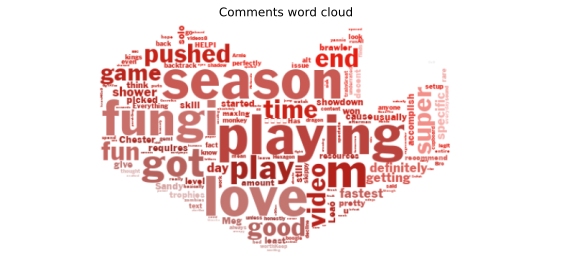

In [26]:
comments_wc = WordCloud(background_color= "white", max_words= 300, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf',
               collocations=False)

image_colors = ImageColorGenerator(np.array(coloring))
comments_wc.generate(comments)
comments_wc = comments_wc.recolor(color_func= image_colors)

comments_svg = comments_wc.to_svg(embed_font=True)

# Save the SVG code to a file
with open("../plots/comments_word_cloud.svg", "w", encoding="utf-8") as f:
    f.write(comments_svg)
    
fig, ax = plt.subplots(1)

ax.imshow(comments_wc, interpolation="bilinear")
ax.set_axis_off()

plt.title("Comments word cloud")
fig.set_size_inches(10, 8)
plt.savefig("../plots/comments_word_cloud.png")
plt.show()

Now we will make a word cloud for **video titles data**

In [27]:
popular_emojis = ["😊", "😍", "😘", "😜", "😝", "😂", "😭", "😡", "😠", "😩", "😫", "😞", "😟", "😢", "😥", "😰", "😱",
                       "😳", "😷", "👍", "👎", "👌", "👏", "🙌", "👋", "💪", "🙏", "❤️", "💔", "💕", "💖", "💘", "💙", "💚",
                       "💛", "💜", "💯", "🔥", "🌟", "✨", "⭐", "🌈", "🌺", "🍕", "🍔", "🍟", "🍦", "🍭", "🍩", "🍪", "🍺",
                       "🍻", "🍷", "🍸", "🎂", "🎁", "🎉", "🎊", "🎈", "🎵", "🎶", "🎼", "🎧", "🎤", "🎸", "🎹", "🎺", "🎷",
                       "🎻", "🎬", "🎥", "🎦", "📷", "📹", "📺", "📻", "💻", "📱", "💡", "🔑", "🔨", "🔥", "💰", "💳", "💼",
                       "📅", "📆", "📈", "📉", "📊", "📋", "📎", "📏", "📐", "🔒", "🔓", "🔍", "🔎", "🚀", "🚑", "🚒", "🚓",
                       "🚕", "🚗", "🚙", "🚚", "🚢", "🚤", "🚲", "🚶", "🚶‍♀️", "🏃", "🏃‍♀️", "⚽", "🏀", "🏈", "🎾", "🏐", "🏉",
                       "🎱", "🏓", "🏸", "🥊", "🥋", "🎮", "🕹️", "🎲", "🃏"]


for emoji in popular_emojis:
    stopwords.add(emoji)
    
titels = ''.join(
    temp_comments_df["title"][temp_comments_df["language"] == "English"].values.flatten())

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


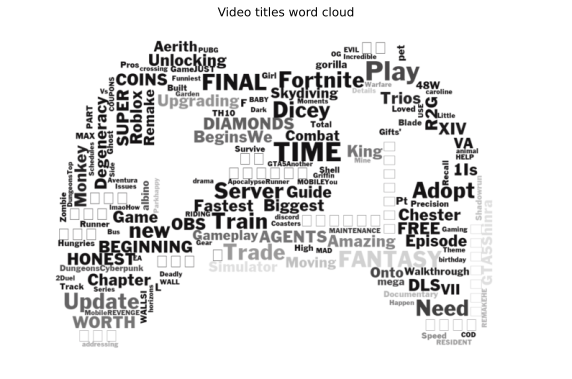

In [28]:
coloring = np.array(Image.open("../imgs/joystick.png"))

titels_wc = WordCloud(background_color= "white", max_words= 2000, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf')

titels_wc.generate(titels)
image_colors = ImageColorGenerator(np.array(coloring))
titels_wc = titels_wc.recolor(color_func= image_colors)


fig, ax = plt.subplots(1)

ax.imshow(titels_wc, interpolation= "bilinear")
ax.set_axis_off()

titels_svg = titels_wc.to_svg(embed_font=True)

with open("../plots/videos_titels_word_cloud.svg", "w", encoding="utf-8") as f:
    f.write(titels_svg)

plt.title("Video titles word cloud")
fig.set_size_inches(10, 8)
plt.savefig("../plots/videos_titels_word_cloud.png")
plt.show()

In [29]:
del temp_comments_df

## <center><strong><span style = "color: red">NLP</span> preprocessing

#### *Removing stop words*

In [32]:
from nltk.corpus import stopwords
# nltk.download()

nltk.download('punkt', force=True)
nltk.download('wordnet', force= True)
nltk.download('stopwords', force=True)
nltk.download('stopwords-hi', force=True)
nltk.download('stopwords-ar', force=True)
nltk.download('averaged_perceptron_tagger', force=True)


en_stopwords = set(stopwords.words('english')) 
ar_stopwords = set(stopwords.words('arabic')) 
# hi_stopwords = set(stopwords.words('hindi')) 

all_stopwords = en_stopwords.union(ar_stopwords)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FreeComp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FreeComp\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FreeComp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Error loading stopwords-hi: Package 'stopwords-hi' not
[nltk_data]     found in index
[nltk_data] Error loading stopwords-ar: Package 'stopwords-ar' not
[nltk_data]     found in index
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\FreeComp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [33]:
def stopwords_dropper(words: list, stopwords: set) -> list:
    
    # Removing stop words from unalphabetical chars
    filtered_words = [re.sub(r"[\W_]", "", word) for word in words
                      if not word in stopwords]
    
    filtered_words = list(filter(lambda item: item != "", filtered_words))
    return  filtered_words


for col in TEXT_COLUMNS:
    df[f"{col}_tokens"] = df[col].apply(lambda text: nltk.word_tokenize(text.lower()))
    df[f"{col}_tokens"] = df[f"{col}_tokens"].apply(lambda text: stopwords_dropper(text,
                                                                     all_stopwords))

df["title_tokens"]

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\FreeComp\AppData\Local\Temp\ipykernel_15180\2117315617.py:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  filtered_words = list(filter(lambda item: item is not "", filtered_words))


0     [impress, cute, girls, omegle, omegle, funny, ...
1                     [rahatlatici, kedi, cafe, calico]
2     [réussir, facilement, le, raid, archéduc, en, ...
3     [super, beginning, 30400, coins, 2085, diamond...
4                [chester, worth, unlocking, upgrading]
5     [upcoming, lighthouse, location, tech, update,...
6     [ಬಗಳರ, goa, train, journey, vasco, express, ka...
7     [การเดนทางสดทรหดของนกแกว, l, สปอยหนง, l, พอลล,...
8     [مغزبازی, زون, آخر, بدون, لوت, ریوایوی, اتچمنت...
9                       [obs, s, biggest, update, ever]
10    [i, became, giant, alex, fooled, girl, minecraft]
11    [honest, guide, final, fantasy, xiv, episode, ...
12    [top, 17, big, changes, ob38, updates, free, f...
13    [trade, get, amazing, monkey, king, roblox, ad...
14           [ausbruch, aus, spielzeug, fabrik, roblox]
15               [fastest, game, ever, fortnite, trios]
16               [skydiving, onto, moving, train, gta5]
17    [shinra, combat, simulator, aerith, va, pl

#### *Part-of-speech (POS) Tagging*

In [34]:
for col in TEXT_COLUMNS:
    df[f"{col}_pos_tags"] = df[f"{col}_tokens"].apply(lambda words: nltk.pos_tag(words))

df["about_pos_tags"]

0     [(hy, NN), (friends, NNS), (nt, JJ), (forget, ...
1     [(daha, NN), (fazla, NN), (oyun, NN), (daha, N...
2     [(hey, NN), (moi, NN), (cest, NN), (boramy, NN...
3     [(focusing, VBG), (quality, NN), (quantity, NN...
4     [(m, NN), (kairostime, NN), (s, JJ), (time, NN...
5     [(hello, NN), (guy, NN), (s, NN), (samuel, NN)...
6     [(free, JJ), (fire, NN), (kannada, NN), (conte...
7     [(โลกนมนเครยด, JJ), (อยาไปซเรยสกบมน, NNP), (ตด...
8     [(سلام, JJ), (کانال, NNP), (خوش, NNP), (آمدید,...
9     [(live, JJ), (streaming, NN), (nutshell, RB), ...
10    [(guys, NNS), (im, VBP), (trying, VBG), (best,...
11    [(pg, NN), (team, NN), (variety, NN), (gaming,...
12    [(hi, NN), (official, NN), (channel, NN), (enj...
13    [(roblox, NN), (gaming, VBG), (family, NN), (s...
14    [(der, NN), (neue, DT), (kanal, JJ), (von, NN)...
15    [(s, NN), (everybody, NN), (typical, JJ), (gam...
16    [(welcome, JJ), (get, VB), (good, JJ), (gaming...
17    [(hi, NN), (m, NN), (bri, VBD), (welcome, 

#### *Lemmatization and dropping duplicated words*

In [35]:
def get_wordnet_pos(treebank_tag: str) -> str:
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN

In [36]:
lemmatizer = WordNetLemmatizer()
lemmatized_words = []
lemmatized_words_group = []

for col in TEXT_COLUMNS:
    for index, row in df.iterrows():
        for token, pos_tag in zip(row[f"{col}_tokens"], row[f"{col}_pos_tags"]):

            wordnet_pos = get_wordnet_pos(pos_tag[1])
            lemmatized_words_group.append(lemmatizer.lemmatize(token, pos= wordnet_pos))
            lemmatized_words_group = list(set(lemmatized_words_group)) # Dropping duplicates


        lemmatized_words.append(lemmatized_words_group)
        lemmatized_words_group = [] # clearing this list
    
    df[f"{col}_tokens"] = lemmatized_words
    lemmatized_words = []

In [37]:
df["channelTitle_tokens"][:5]

0    [panda, gaming, crazy]
1              [dk, gaming]
2          [gaming, boramy]
3          [game, hd, gang]
4      [kairostime, gaming]
Name: channelTitle_tokens, dtype: object

#### *One hot encoding*

In [44]:
df["language"] = df["language"].astype("category")# .cat.codes
df["definition"] = df["definition"].astype("category")# .cat.codes
df["country"] = df["country"].astype("category")
df["sentiments"] = df["sentiments"].astype(np.int8)

df["cat_view_count"] = df["cat_view_count"].replace({"from 1 to 3,000": 1, "from 3,000 to 10,000": 2,
                                                     "from 10,000 to 50,000": 3, "from 50,000 to 100,000": 4,
                                                     "from 100,000 to 300,000": 5, "more than 300,000": 6})

df["cat_like_count"] = df["cat_like_count"].replace({"from 1 to 1,000": 1, "from 1,000 to 5,000": 2,
                                                     "from 5,000 to 10,000": 3, "from 10,000 to 50,000": 4,
                                                     "from 50,000 to 150,000": 5, "more than 150,000": 6})

df["cat_comment_count"] = df["cat_comment_count"].replace({"from 50 to 100": 1, "from 100 to 150": 2,
                                                           "from 150 to 200": 3, "from 200 to 400": 4,
                                                           "from 400 to 600": 5, "more than 600": 6})

In [42]:
df[["language", "definition", "cat_view_count",
    "cat_like_count", "cat_comment_count", "sentiments"]].sample(5)

,language,definition,cat_view_count,cat_like_count,cat_comment_count,sentiments
42,Chinese,hd,5,2,4,1
11,English,hd,3,2,4,2
35,Turkish,hd,3,2,3,1
20,English,hd,4,2,2,1
23,English,hd,3,1,2,1


## <center><strong><span style = "color: red">Text</span> classification

#### *Preparing training & testing data*

In [132]:
# Changing dtypes of some colums:hh
df = df.astype({"total_views": np.uint64, "video_count": np.uint16,
                "duration_in_minutes": np.float32, "date": "datetime64[ns]",
                "publishedAt": "datetime64[ns]"})


# Those are just temporary text columns not the main one.
text_cols = ["tags", "about_tokens", "title_tokens",
             "channelTitle_tokens", "description_tokens"]

cat_cols = ["country", "language", "definition"]

numeric_cols = [*df.select_dtypes(NUMERICS).columns]

target_cols = ["cat_view_count", "cat_like_count", "cat_comment_count"]

date_cols = ["date", "publishedAt"]



X = df[numeric_cols + cat_cols + date_cols + text_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1/ 5, random_state= 99)

print(f"The shape of the X train data is: {X_train.shape}")
print(f"The shape of the y test data is: {y_test.shape}")

del X, y

The shape of the X train data is: (38, 24)
The shape of the y test data is: (10, 3)


In [133]:
# print([col + ' length is : ' + str(len(X_train[col])) for col in X_train.columns])

#### *preprocessing*

https://towardsdatascience.com/how-to-combine-textual-and-numerical-features-for-machine-learning-in-python-dc1526ca94d9

In [134]:
True * 2 * False + True * 634 // 4

158

In [135]:
# This object is just made to pass columns into sklearn functions
# without any change

class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X

In [136]:
text_cols

['tags',
 'about_tokens',
 'title_tokens',
 'channelTitle_tokens',
 'description_tokens']

In [139]:
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

for X in (X_train, X_test):
    
    for col in X[text_cols].columns:
         X[col] = X[col].astype(str)
    
    
    stacked_text = X[text_cols].agg(', '.join, axis=1).astype(str)
    stacked_text.replace("[", "", inplace= True)
    stacked_text.replace("]", "", inplace= True)
        
    X.drop(text_cols, inplace= True, axis= 1)

    preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, cat_cols),
        ('num', scaler, numeric_cols)
    ])

    if X.shape == X_train.shape:
        X_train = preprocessor.fit_transform(X)
        X = np.append((X, stacked_text.to_numpy(), 1))

    elif X.shape == X_test.shape:
        X_test = preprocessor.fit_transform(X)
        X = np.append((X, stacked_text.to_numpy(), 1))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [138]:
len(stacked_text)

38

In [131]:
X_test[1: 5]

array([[ 0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         1.        ,  0.27214812, -0.1202706 ,  1.08969061,  0.35723637,
         0.02494485,  1.39513872, -0.1111673 ,  0.        ,  0.        ,
         0.        , -1.58711242, -0.12280971,  0.33333333, -0.45542223],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        , -0.52990126, -0.47568802, -0.5071284 , -0.90614414,
        -0.59779393, -0.31932692,  2.79475823,  0.        ,  0.        ,
         0.        ,  0.81933963, -0.67476347, -0.5       , -0.69222487],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         1.        , -0.13189566,  0.68544423, -0.72646041, -1.19951766,
         2.68229981,  0.75989419, -0.46849078,  0.        ,  0.        ,
         0.        ,  0.47556076, -1.13702475,  2.        , -0.52308012],
       [ 0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         1.        , -0.44763677, -0.37704598,  

In [ ]:
X[text_cols] = 

In [87]:
X_train

,viewCount,likeCount,commentCount,duration_in_minutes,subscribers,total_views,video_count,title_emojis_count,desc_emojis_count,comments_emojis_count,...,country,language,definition,date,publishedAt,tags,about_tokens,title_tokens,channelTitle_tokens,description_tokens
33,17532,962,58,19.828125,123000,6180511,311,0,0,0,...,CA,English,hd,2019-12-16,2023-01-22 09:00:10,"['pubg mobile', 'pubgm', 'pubgmvip', 'PUBG MOB...","[blue, channel, welcome, gaming]",[mad],"[blue, gaming]","[rezapanahi299, pubgmvip, wwwinstagramcomblueg..."
10,144703,5977,628,20.187500,694000,79491185,415,1,1,6,...,IN,Hindi,hd,2019-08-22,2023-03-02 07:30:08,['Trolling My New Girlfriend as GIANT ALEX in ...,"[logo, ish, maro, gaminginsectbusiness, app, g...","[minecraft, girl, i, alex, become, giant, fool]","[game, insect]","[8sister, 4minecraft, war, 5minecraft, install..."
6,3316,658,69,9.101562,112000,1605435,296,0,0,0,...,IN,Hindi,hd,2019-07-19,2023-03-29 11:46:46,"['kannada songs', 'dv', 'kannada vlog', 'dr br...","[plz, kannada, free, thank, support, content, ...","[kannada, journey, vlogsnight, express, vasco,...","[game, volter, yt]","[wwwyoutubecomchannelucprr1j9tbtsatgqd7j3tea, ..."
22,1028755,35144,2900,89.312500,187000,19574396,57,0,0,0,...,US,English,hd,2016-05-02,2020-12-15 16:01:57,"['cyberpunk part 2', 'cyberpunk documentary pa...","[specification, livestreams, 860, 64bit, plate...","[cyberpunk, 2, shell, total, recall, blade, do...","[indigo, gaming]","[cyber, 2010, 5828, 1210, man, ocremixorgremix..."
3,1133417,14870,346,33.718750,346000,103937897,84,0,0,0,...,US,English,hd,2018-11-27,2023-01-13 11:00:37,"['dls 23', 'dls', 'dream league soccer 2023', ...","[highquality, quantity, focus, enquire, video,...","[r2g, 23, begin, free, coin, super, dls, agent...","[game, hd, gang]","[r2g, coin, super, instagram, ggofficialcom, a..."
42,175756,1831,231,413.500000,431000,92148939,725,0,0,0,...,TW,Chinese,hd,2013-05-24,2022-02-23 09:00:12,"['gameplay', 'ultra settings', 'max settings',...","[如果您覺得本頻道做的不錯歡迎透過, semenixpcgamingblogspottw20...","[horizonforbidden, 地平線西域禁地4k電影剪輯版, semenix出品, ...","[game, semenix]","[gc573, 034007, 4k, wwwyoutubecomchanneluc6lhn..."
24,43701,1954,88,12.882812,432000,154452839,1496,0,0,0,...,CA,English,hd,2016-01-01,2023-03-26 17:15:05,"['kan gaming', 'zeepkist', 'trackmania', 'game...","[game, video, life]","[pro, speed, track, love, high, build, precision]","[gaming, kan]","[storesteampoweredcomapp1440670zeepkist, every..."
32,637254,20420,1362,33.656250,1300000,201007558,346,0,0,0,...,JP,Japanese,hd,2021-09-22,2023-03-04 08:00:15,"['humanfallflat', ""Johnny'sGamingRoom"", 'ジャニーズ...","[man, 重岡大毅, 深澤辰哉, 森本慎太郎, say, 佐藤勝利, sexy, ジャニー...","[フォール, フラット, 犬ピンチステージアイスヒューマン]","[s, johnny, room, gaming]","[はじめは苦戦するものの持ち前のセンスで, wwwyoutubecomchannelucvm..."
44,10516,430,82,10.046875,24900,3238246,173,0,0,4,...,FI,Finnish,hd,2018-05-07,2020-07-17 12:00:17,"['ylekioski', 'gaming', 'yle kioski gaming', '...","[peleistä, hauskimmat, täältä, luotsaamana, ki...","[c, rankataan, alkuvuoden, parhaat, pelaajat, go]","[yle, gaming, kioski]","[kioskia, csgo, ehti, robujohnson, youtubecomy..."
17,7859,482,57,79.250000,207000,20507678,365,0,0,0,...,US,English,hd,2015-08-10,2022-11-22 17:00:15,"['StrangeRebelGaming', 'TheStrangeRebel', 'Bri...","[create, help, base, comment, bri, since, ll, ...","[va, simulator, shinra, aerith, final, pt, fan...","[rebel, strange, gaming]","[bri, watch, dr, high, instagram, listplens2fu..."


In [65]:
R = 412
r1 = R
r2 = R + 5

id(r2)

2207201593904

In [ ]:
pd.DataFrame(X_train)

#### *Training the models*

In [ ]:
[txt_col for txt_col.apply(lambda x: ' '.join(x)) in X[text_cols]]

temp_txt_cols = []

for txt_col in X[text_cols]:
    
    X[txt_col].apply(lambda x: ' '.join(x))
    temp_txt_cols.append(X[txt_col])
    X["my_new_text"]X[text_cols].agg(', '.join, axis=1)
    

In [ ]:
X["my_new_text"] = X[text_cols].apply(lambda x: ', '.join(x), axis=1)

In [ ]:
X["my_new_text"] = X[text_cols].apply(lambda x: ', '.join(map(str, x)), axis=1)
X["my_new_text"][1]

In [ ]:
tfidf.fit_transform(df[].apply(lambda x: ' '.join(x)))


In [ ]:
def model_report(y_true, y_pred):

    pre = precision_score(y_true, y_pred, average= "micro")
    rec = recall_score(y_true, y_pred, average= "micro")
    f1 = f1_score(y_true, y_pred, average= "micro")
  # loss = log_loss(y_true, y_pred, normalize= False)
    acc = accuracy_score(y_true, y_pred)

    print("| precision: {:4f}        |\n".format(pre) + \
          "| recall: {:4f}           |\n".format(rec) + \
          "| f1-score: {:4f}         |\n".format(f1) + \
          "| accuracy: {:4f}         |".format(acc))